# Introduction

## Objectif du Notebook

L'objectif de ce notebook est de développer et d'évaluer des modèles d'analyse de sentiments en utilisant **BERT** (Bidirectional Encoder Representations from Transformers), tout en comparant différentes versions des données textuelles : avec et sans pré-traitements (lemmatisation et stemming). BERT, étant un modèle pré-entraîné puissant, nous permet de capturer les relations contextuelles entre les mots dans un texte. En parallèle, nous allons comparer les performances des modèles CNN et LSTM entraînés sur des textes bruts et pré-traités.

## Présentation de la Méthode BERT

BERT est un modèle de traitement du langage naturel basé sur une architecture de **Transformers**, permettant de capturer de manière bidirectionnelle les relations entre les mots. BERT est particulièrement efficace pour des tâches telles que l'analyse de sentiments car il tient compte du contexte des mots dans les phrases, contrairement aux modèles classiques comme Word2Vec qui sont unidirectionnels.

### BERT (Bidirectional Encoder Representations from Transformers)

BERT prend en compte le contexte avant et après un mot pour créer des représentations contextuelles riches. C'est pourquoi il est très performant pour des tâches de compréhension sémantique, comme la classification de sentiments, où l'interprétation d'un mot dépend de son contexte global.

### Comparaison avec et sans Pré-traitements (Lemmatisation et Stemming)

Dans ce notebook, nous utiliserons à la fois :
- **Les textes pré-traités** (lemmatisation et stemming) : Ces techniques consistent à ramener les mots à leur forme de base ou à leur racine pour réduire la variabilité linguistique. Cela permet de simplifier les phrases avant de les soumettre à BERT.
- **Les textes bruts** : Sans aucun pré-traitement linguistique, laissant à BERT la capacité d'analyser les mots dans leur forme originale et de capturer les nuances du langage.

L'objectif est de comparer l'impact du pré-traitement sur les performances du modèle BERT.

## Plan du Notebook

1. **Chargement et Préparation des Données** : Nous allons charger les données, les nettoyer, les tokeniser, et les préparer sous trois formats : brut, lemmatisé et stemmé.
2. **Tokenisation avec BERT** : Nous utiliserons le tokenizer BERT pour convertir les trois versions de textes en tokens adaptés au modèle BERT.
3. **Utilisation de BERT** : Nous extrairons des embeddings contextuels à partir du modèle BERT pour chaque version des données.
4. **Construction des Modèles CNN et LSTM** : Nous entraînerons deux types de modèles (CNN et LSTM) sur les embeddings extraits de BERT pour chaque version de données.
5. **Entraînement des Modèles** : Nous entraînerons les modèles sur les différentes versions des embeddings BERT.
6. **Comparaison des Modèles** : Nous comparerons les performances des modèles CNN et LSTM avec les embeddings BERT pour les données brutes, lemmatisées et stemmées.
7. **Export du Meilleur Modèle** : Nous exporterons le modèle le plus performant pour une utilisation future dans une API de prédiction.


# 1. Importation des Bibliothèques

In [4]:
import numpy as np
import pandas as pd
import mlflow
import mlflow.keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, TFBertModel


# 2. Chargement des Données

In [6]:
# Charger les données (en supposant que vous avez déjà les colonnes nettoyées)
data = pd.read_csv('../data/database_p7_rework.csv')

# Transformation des labels : 0 reste 0 et 4 devient 1
data['target_binary'] = data['target'].apply(lambda x: 0 if x == 0 else 1)

# Vérification des transformations
print(data['target_binary'].value_counts())

# Ensuite, définissez y comme suit :
y = data['target_binary']

0    800000
1    798315
Name: target_binary, dtype: int64


# 3. Préparation des Données
Tokenization avec BERT

In [18]:
from transformers import BertTokenizer

# Initialisation du tokenizer BERT pré-entraîné pour les textes en minuscules et sans caractères spéciaux
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Fonction pour préparer les séquences BERT
def prepare_sequences_bert(texts, tokenizer, maxlen=100):
    return tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=maxlen, return_tensors='tf')

# Sélection d'un échantillon équilibré de 16 000 données (8 000 par classe)
sample_data = data.groupby('target_binary', group_keys=False).apply(lambda x: x.sample(8000, random_state=42))

# Préparation des séquences avec une longueur max de 100
X_cleaned_sample = prepare_sequences_bert(sample_data['text_cleaned'], tokenizer, maxlen=100)

# Cible (target) - identique pour toutes les variantes
y_sample = sample_data['target_binary'].values

print("Données préparées avec succès.")


D:\Master_Openclassroom\python\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Données préparées avec succès.


In [20]:
from transformers import TFBertModel

# Charger le modèle BERT pré-entraîné
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

print("Modèle BERT chargé avec succès.")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Modèle BERT chargé avec succès.


In [22]:
import tensorflow as tf

# Fonction pour extraire les embeddings à partir de BERT par batchs
def get_bert_embeddings_in_batches(sequences, attention_mask, bert_model, batch_size=32):
    embeddings = []
    for i in range(0, len(sequences), batch_size):
        batch_sequences = sequences[i:i + batch_size]
        batch_mask = attention_mask[i:i + batch_size]
        # Générer les embeddings pour chaque batch
        batch_embeddings = bert_model(batch_sequences, attention_mask=batch_mask).last_hidden_state
        embeddings.append(batch_embeddings)
    return tf.concat(embeddings, axis=0)


In [30]:
from sklearn.model_selection import train_test_split

# Récupérer les input_ids et attention_mask des séquences préparées
X_cleaned_sample_input_ids = X_cleaned_sample['input_ids'].numpy()  # Convertir en numpy
X_cleaned_sample_attention_mask = X_cleaned_sample['attention_mask'].numpy()  # Convertir en numpy

# Split en données d'entraînement et de test avec stratification
X_train_cleaned_ids, X_test_cleaned_ids, y_train_cleaned, y_test_cleaned = train_test_split(
    X_cleaned_sample_input_ids, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

X_train_mask, X_test_mask = train_test_split(
    X_cleaned_sample_attention_mask, test_size=0.2, random_state=42, stratify=y_sample)

print("Données scindées en ensemble d'entraînement et de test.")


Générateurs d'entraînement et de test créés.


In [34]:
# Générer les embeddings pour les ensembles d'entraînement et de test
X_train_embeddings = get_bert_embeddings_in_batches(train_generator, bert_model, batch_size=32)
X_test_embeddings = get_bert_embeddings_in_batches(test_generator, bert_model, batch_size=32)

print("Embeddings BERT générés pour les ensembles d'entraînement et de test.")

TypeError: object of type 'generator' has no len()

# Construction des modèles CNN et LSTM avec BERT

In [212]:
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential

# Fonction pour créer un modèle avec Dense, sans Conv1D
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=input_shape))  # Suppression de Conv1D, utilisation de Dense
    model.add(BatchNormalization())  # Ajout de BatchNorm
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.1))  # Remplacer ReLU par LeakyReLU
    model.add(Dropout(0.5))  # Dropout plus fort
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [341]:
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential

# Fonction pour créer un modèle LSTM sans la couche d'embedding, car les embeddings BERT sont déjà calculés
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(256, dropout=0.3, recurrent_dropout=0.3, input_shape=input_shape)))  # LSTM bidirectionnel
    model.add(BatchNormalization())  # Ajout de BatchNorm
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))  # Augmenter Dropout
    model.add(Dense(64, activation='relu'))  # Couche Dense supplémentaire
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# 4 Evaluation des modèles avec MLflow

In [218]:
# Définir le dossier racine où vous voulez enregistrer les artefacts MLflow
base_dir = os.path.join("..", "mlruns")

# Fonction pour configurer MLflow pour chaque modèle
def configure_mlflow(model_name):
    mlflow_base_dir = os.path.join(base_dir, model_name)
    if not os.path.exists(mlflow_base_dir):
        os.makedirs(mlflow_base_dir)
    mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")


In [312]:
import numpy as np

def preprocess_data(X):
    """
    Vérifie et formate les données pour qu'elles aient la forme (batch_size, 1, 768).
    
    Args:
    - X : ndarray, les données d'entrée
    
    Returns:
    - X : ndarray, les données d'entrée avec la forme (batch_size, 1, 768)
    """
    # Suppression de toutes les dimensions inutiles, mais en conservant (batch_size, 1, 768)
    while len(X.shape) > 3:
        X = np.squeeze(X, axis=1)  # Supprimer les dimensions inutiles à 1 jusqu'à avoir (batch_size, 1, 768)

    # Si X est sous forme (batch_size, 768), ajouter une dimension pour avoir (batch_size, 1, 768)
    if len(X.shape) == 2 and X.shape[1] == 768:
        X = np.expand_dims(X, axis=1)
    
    # Vérification finale pour s'assurer que la forme est correcte
    if len(X.shape) == 3 and X.shape[1] == 1 and X.shape[2] == 768:
        return X
    else:
        raise ValueError(f"Forme inattendue des données : {X.shape}. Attendu (batch_size, 1, 768).")


In [330]:
# Supposons que X_train_stem ait une forme incorrecte (1278652, 1, 1, 1, 1, 1, 768)
X_train_stem = preprocess_data(X_train_stem)  # Met les données sous la forme (batch_size, 1, 768)
X_test_stem = preprocess_data(X_test_stem)

# De même pour les données lemmatisées
X_train_lemma = preprocess_data(X_train_lemma)
X_test_lemma = preprocess_data(X_test_lemma)


In [332]:
print(X_train_lemma.shape)
print(X_train_stem.shape)
print(X_test_stem.shape)
print(X_test_lemma.shape)

(1278652, 1, 768)
(1278652, 1, 768)
(319663, 1, 768)
(319663, 1, 768)


## 4.1 Modele cnn_model_lemma_bert

D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 156s 5ms/step - accuracy: 0.7655 - loss: 0.4883 - val_accuracy: 0.7889 - val_loss: 0.4495
Epoch 2/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 155s 5ms/step - accuracy: 0.7835 - loss: 0.4598 - val_accuracy: 0.7918 - val_loss: 0.4443
Epoch 3/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 156s 5ms/step - accuracy: 0.7881 - loss: 0.4530 - val_accuracy: 0.7931 - val_loss: 0.4421
Epoch 4/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 156s 5ms/step - accuracy: 0.7898 - loss: 0.4486 - val_accuracy: 0.7907 - val_loss: 0.4451
Epoch 5/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 154s 5ms/step - accuracy: 0.7914 - loss: 0.4453 - val_accuracy: 0.7958 - val_loss: 0.4376
Epoch 6/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 154s 5ms/step - accuracy: 0.7926 - loss: 0.4428 - val_accuracy: 0.7965 - val_loss: 0.4352
Epoch 7/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 155s 5ms/step - accuracy: 0.7947 - loss: 0.4400 - val_accuracy: 0.7958 - val_loss: 0.4371
Epoch 8/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 157s 5ms/step - ac

2024/09/22 19:27:53 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/22 19:27:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 8s 765us/step
Shape of y_test_lemma: (319663,)
Shape of y_pred_cnn_lemma_bert: (319663,)
Accuracy: 0.7963230026621786
Precision: 0.8098088773662337
Recall: 0.7758756272311955
F1 Score: 0.7924791707836376


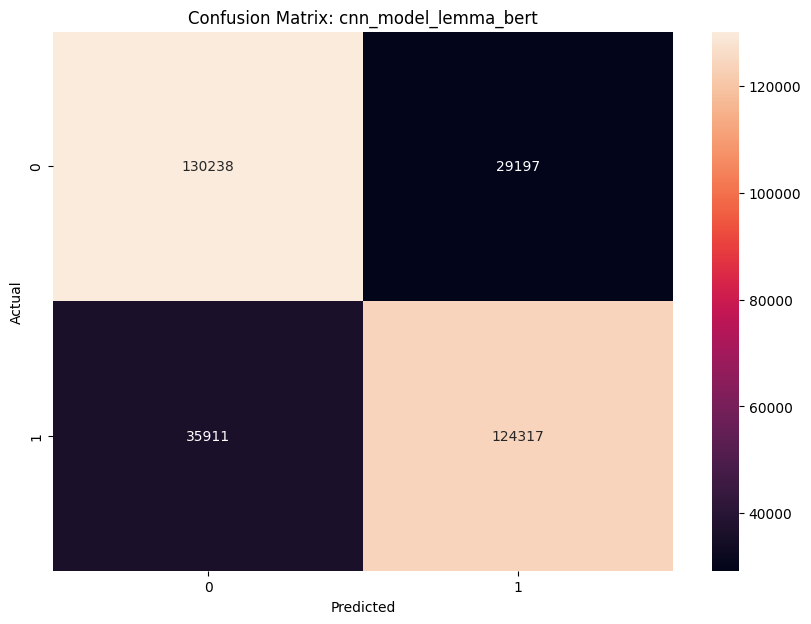

In [335]:

# Vérification de la forme d'entrée
input_shape = (1, 768)  # Longueur de la séquence (1), Taille de l'embedding (768)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import mlflow

# Entraînement et évaluation du modèle CNN avec les données lemmatisées
model_name = "cnn_model_lemma_bert"
model = create_cnn_model(input_shape=input_shape)  # Utilisation des caractéristiques BERT pré-calculées

configure_mlflow(model_name)

with mlflow.start_run():
    # Entraînement du modèle avec validation
    history = model.fit(X_train_lemma, y_train_lemma, batch_size=32, epochs=10, validation_split=0.2)
    
    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(model, model_name)
    
    # Faire des prédictions
    y_test_lemma = y_test_lemma.astype("int32")  # S'assurer que y_test_lemma est de type int32
    y_pred_cnn_lemma_bert = (model.predict(X_test_lemma) > 0.5).astype("int32")  # Convertir les prédictions en binaire (0/1)
    
    # Suppression des dimensions inutiles dans y_pred_cnn_lemma_bert
    y_pred_cnn_lemma_bert = np.squeeze(y_pred_cnn_lemma_bert)  # Transforme (319663, 1, 1) en (319663,)
    
    # Vérification des formes après squeeze
    print(f"Shape of y_test_lemma: {y_test_lemma.shape}")
    print(f"Shape of y_pred_cnn_lemma_bert: {y_pred_cnn_lemma_bert.shape}")
    
    # Calcul des métriques de performance
    accuracy_cnn_lemma_bert = accuracy_score(y_test_lemma, y_pred_cnn_lemma_bert)
    precision_cnn_lemma_bert = precision_score(y_test_lemma, y_pred_cnn_lemma_bert)
    recall_cnn_lemma_bert = recall_score(y_test_lemma, y_pred_cnn_lemma_bert)
    f1_cnn_lemma_bert = f1_score(y_test_lemma, y_pred_cnn_lemma_bert)
    
    # Affichage des résultats
    print(f"Accuracy: {accuracy_cnn_lemma_bert}")
    print(f"Precision: {precision_cnn_lemma_bert}")
    print(f"Recall: {recall_cnn_lemma_bert}")
    print(f"F1 Score: {f1_cnn_lemma_bert}")
    
    # Enregistrer les métriques dans MLflow
    mlflow.log_metric("accuracy", accuracy_cnn_lemma_bert)
    mlflow.log_metric("precision", precision_cnn_lemma_bert)
    mlflow.log_metric("recall", recall_cnn_lemma_bert)
    mlflow.log_metric("f1_score", f1_cnn_lemma_bert)
    
    # Créer et afficher la matrice de confusion
    cm = confusion_matrix(y_test_lemma, y_pred_cnn_lemma_bert)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 4.2 Modele cnn_model_stem_bert

D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 153s 5ms/step - accuracy: 0.7386 - loss: 0.5262 - val_accuracy: 0.7609 - val_loss: 0.4889
Epoch 2/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 147s 5ms/step - accuracy: 0.7607 - loss: 0.4949 - val_accuracy: 0.7656 - val_loss: 0.4838
Epoch 3/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 147s 5ms/step - accuracy: 0.7635 - loss: 0.4896 - val_accuracy: 0.7579 - val_loss: 0.4922
Epoch 4/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 146s 5ms/step - accuracy: 0.7649 - loss: 0.4860 - val_accuracy: 0.7701 - val_loss: 0.4743
Epoch 5/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 147s 5ms/step - accuracy: 0.7673 - loss: 0.4824 - val_accuracy: 0.7706 - val_loss: 0.4742
Epoch 6/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 148s 5ms/step - accuracy: 0.7694 - loss: 0.4795 - val_accuracy: 0.7710 - val_loss: 0.4737
Epoch 7/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 147s 5ms/step - accuracy: 0.7701 - loss: 0.4785 - val_accuracy: 0.7736 - val_loss: 0.4707
Epoch 8/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 147s 5ms/step - ac

2024/09/22 19:01:37 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/22 19:01:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 8s 759us/step
Shape of y_test_stem: (319663,)
Shape of y_pred_cnn_stem_bert: (319663,)
Accuracy: 0.7748754156721297
Precision: 0.7736121616427145
Recall: 0.7787590183987817
F1 Score: 0.7761770578685128


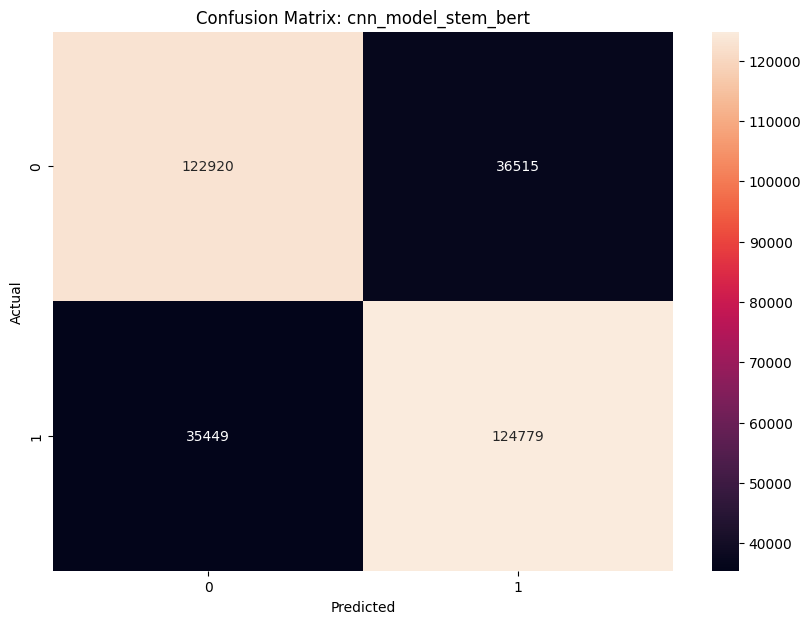

In [334]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import mlflow

# Entraînement et évaluation du modèle CNN avec les données stemmées
model_name = "cnn_model_stem_bert"
model = create_cnn_model(input_shape=input_shape)  # Utilisation des caractéristiques BERT pré-calculées

configure_mlflow(model_name)

with mlflow.start_run():
    # Entraînement du modèle avec validation
    history = model.fit(X_train_stem, y_train_stem, batch_size=32, epochs=10, validation_split=0.2)
    
    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(model, model_name)
    
    # Faire des prédictions
    y_test_stem = y_test_stem.astype("int32")  # S'assurer que y_test_stem est de type int32
    y_pred_cnn_stem_bert = (model.predict(X_test_stem) > 0.5).astype("int32")  # Convertir les prédictions en binaire (0/1)
    
    # Suppression des dimensions inutiles dans y_pred_cnn_stem_bert
    y_pred_cnn_stem_bert = np.squeeze(y_pred_cnn_stem_bert)  # Transforme (nombre d'exemples, 1, 1) en (nombre d'exemples,)
    
    # Vérification des formes après squeeze
    print(f"Shape of y_test_stem: {y_test_stem.shape}")
    print(f"Shape of y_pred_cnn_stem_bert: {y_pred_cnn_stem_bert.shape}")
    
    # Calcul des métriques de performance
    accuracy_cnn_stem_bert = accuracy_score(y_test_stem, y_pred_cnn_stem_bert)
    precision_cnn_stem_bert = precision_score(y_test_stem, y_pred_cnn_stem_bert)
    recall_cnn_stem_bert = recall_score(y_test_stem, y_pred_cnn_stem_bert)
    f1_cnn_stem_bert = f1_score(y_test_stem, y_pred_cnn_stem_bert)
    
    # Affichage des résultats
    print(f"Accuracy: {accuracy_cnn_stem_bert}")
    print(f"Precision: {precision_cnn_stem_bert}")
    print(f"Recall: {recall_cnn_stem_bert}")
    print(f"F1 Score: {f1_cnn_stem_bert}")
    
    # Enregistrer les métriques dans MLflow
    mlflow.log_metric("accuracy", accuracy_cnn_stem_bert)
    mlflow.log_metric("precision", precision_cnn_stem_bert)
    mlflow.log_metric("recall", recall_cnn_stem_bert)
    mlflow.log_metric("f1_score", f1_cnn_stem_bert)
    
    # Créer et afficher la matrice de confusion
    cm = confusion_matrix(y_test_stem, y_pred_cnn_stem_bert)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 4.2 Modele lstm_model_lemma_bert

D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 718s 22ms/step - accuracy: 0.7540 - loss: 0.5075 - val_accuracy: 0.7859 - val_loss: 0.4547
Epoch 2/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 701s 22ms/step - accuracy: 0.7744 - loss: 0.4772 - val_accuracy: 0.7888 - val_loss: 0.4489
Epoch 3/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 684s 21ms/step - accuracy: 0.7757 - loss: 0.4739 - val_accuracy: 0.7898 - val_loss: 0.4490
Epoch 4/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 681s 21ms/step - accuracy: 0.7767 - loss: 0.4713 - val_accuracy: 0.7872 - val_loss: 0.4522
Epoch 5/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 683s 21ms/step - accuracy: 0.7782 - loss: 0.4689 - val_accuracy: 0.7911 - val_loss: 0.4500
Epoch 6/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 684s 21ms/step - accuracy: 0.7793 - loss: 0.4666 - val_accuracy: 0.7906 - val_loss: 0.4484
Epoch 7/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 681s 21ms/step - accuracy: 0.7802 - loss: 0.4663 - val_accuracy: 0.7924 - val_loss: 0.4477
Epoch 8/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 683s 21ms/s

2024/09/22 22:05:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/22 22:05:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step
Shape of y_test_lemma: (319663,)
Shape of y_pred_lstm_lemma_bert: (319663,)
Accuracy: 0.7920466241010063
Precision: 0.7732224352884263
Recall: 0.8279514192276006
F1 Score: 0.799651594197657


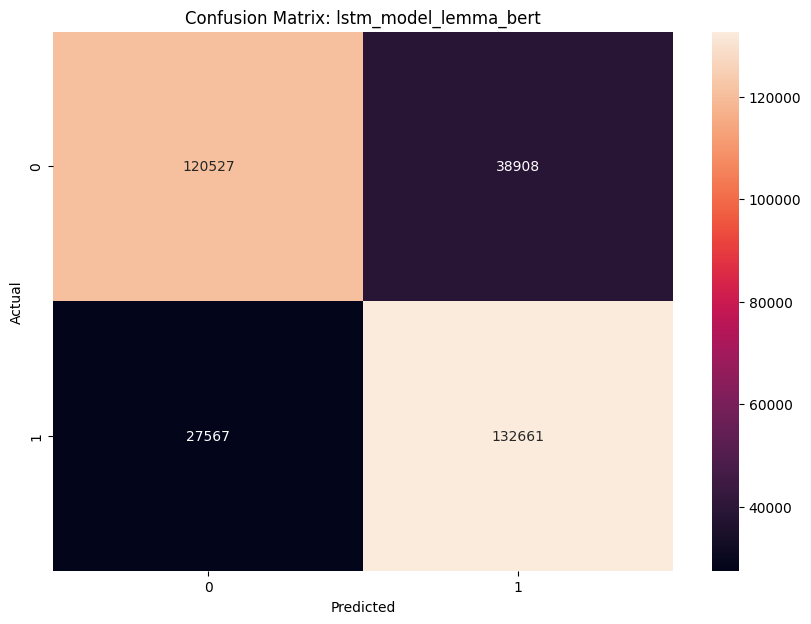

In [347]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import mlflow

# Entraînement et évaluation du modèle LSTM avec les données lemmatisées
model_name = "lstm_model_lemma_bert"
model = create_lstm_model(input_shape=input_shape)  # Utilisation des caractéristiques BERT pré-calculées

configure_mlflow(model_name)

with mlflow.start_run():
    # Entraînement du modèle avec validation
    history = model.fit(X_train_lemma, y_train_lemma, batch_size=32, epochs=10, validation_split=0.2)
    
    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(model, model_name)
    
    # Faire des prédictions
    y_test_lemma = y_test_lemma.astype("int32")  # S'assurer que y_test_lemma est de type int32
    y_pred_lstm_lemma_bert = (model.predict(X_test_lemma) > 0.5).astype("int32")  # Convertir les prédictions en binaire (0/1)
    
    # Suppression des dimensions inutiles dans y_pred_lstm_lemma_bert
    y_pred_lstm_lemma_bert = np.squeeze(y_pred_lstm_lemma_bert)  # Transforme (nombre d'exemples, 1, 1) en (nombre d'exemples,)
    
    # Vérification des formes après squeeze
    print(f"Shape of y_test_lemma: {y_test_lemma.shape}")
    print(f"Shape of y_pred_lstm_lemma_bert: {y_pred_lstm_lemma_bert.shape}")
    
    # Calcul des métriques de performance
    accuracy_lstm_lemma_bert = accuracy_score(y_test_lemma, y_pred_lstm_lemma_bert)
    precision_lstm_lemma_bert = precision_score(y_test_lemma, y_pred_lstm_lemma_bert)
    recall_lstm_lemma_bert = recall_score(y_test_lemma, y_pred_lstm_lemma_bert)
    f1_lstm_lemma_bert = f1_score(y_test_lemma, y_pred_lstm_lemma_bert)
    
    # Affichage des résultats
    print(f"Accuracy: {accuracy_lstm_lemma_bert}")
    print(f"Precision: {precision_lstm_lemma_bert}")
    print(f"Recall: {recall_lstm_lemma_bert}")
    print(f"F1 Score: {f1_lstm_lemma_bert}")
    
    # Enregistrer les métriques dans MLflow
    mlflow.log_metric("accuracy", accuracy_lstm_lemma_bert)
    mlflow.log_metric("precision", precision_lstm_lemma_bert)
    mlflow.log_metric("recall", recall_lstm_lemma_bert)
    mlflow.log_metric("f1_score", f1_lstm_lemma_bert)
    
    # Créer et afficher la matrice de confusion
    cm = confusion_matrix(y_test_lemma, y_pred_lstm_lemma_bert)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 743s 23ms/step - accuracy: 0.7257 - loss: 0.5452 - val_accuracy: 0.7593 - val_loss: 0.4959
Epoch 2/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 723s 23ms/step - accuracy: 0.7450 - loss: 0.5160 - val_accuracy: 0.7645 - val_loss: 0.4885
Epoch 3/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 703s 22ms/step - accuracy: 0.7493 - loss: 0.5109 - val_accuracy: 0.7658 - val_loss: 0.4860
Epoch 4/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 697s 22ms/step - accuracy: 0.7506 - loss: 0.5072 - val_accuracy: 0.7652 - val_loss: 0.4941
Epoch 5/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 693s 22ms/step - accuracy: 0.7523 - loss: 0.5056 - val_accuracy: 0.7645 - val_loss: 0.4911
Epoch 6/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 696s 22ms/step - accuracy: 0.7536 - loss: 0.5040 - val_accuracy: 0.7648 - val_loss: 0.4942
Epoch 7/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 700s 22ms/step - accuracy: 0.7551 - loss: 0.5030 - val_accuracy: 0.7690 - val_loss: 0.5001
Epoch 8/10
31967/31967 ━━━━━━━━━━━━━━━━━━━━ 703s 22ms/s

2024/09/23 00:03:45 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/23 00:03:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step
Shape of y_test_stem: (319663,)
Shape of y_pred_lstm_stem_bert: (319663,)
Accuracy: 0.766798159311525
Precision: 0.7433318186981711
Recall: 0.81677983872981
F1 Score: 0.7783269102673899


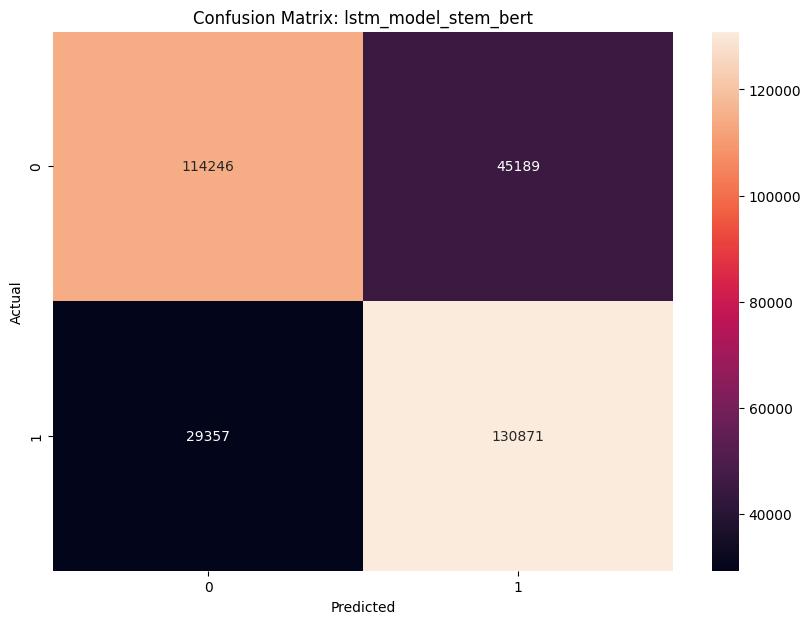

In [348]:
# Vérification de la forme d'entrée
input_shape = (1, 768)  # Longueur de la séquence (1), Taille de l'embedding (768)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import mlflow

# Entraînement et évaluation du modèle LSTM avec les données stemmées
model_name = "lstm_model_stem_bert"
model = create_lstm_model(input_shape=input_shape)  # Utilisation des caractéristiques BERT pré-calculées

configure_mlflow(model_name)

with mlflow.start_run():
    # Entraînement du modèle avec validation
    history = model.fit(X_train_stem, y_train_stem, batch_size=32, epochs=10, validation_split=0.2)
    
    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(model, model_name)
    
    # Faire des prédictions
    y_test_stem = y_test_stem.astype("int32")  # S'assurer que y_test_stem est de type int32
    y_pred_lstm_stem_bert = (model.predict(X_test_stem) > 0.5).astype("int32")  # Convertir les prédictions en binaire (0/1)
    
    # Suppression des dimensions inutiles dans y_pred_lstm_stem_bert
    y_pred_lstm_stem_bert = np.squeeze(y_pred_lstm_stem_bert)  # Transforme (nombre d'exemples, 1, 1) en (nombre d'exemples,)
    
    # Vérification des formes après squeeze
    print(f"Shape of y_test_stem: {y_test_stem.shape}")
    print(f"Shape of y_pred_lstm_stem_bert: {y_pred_lstm_stem_bert.shape}")
    
    # Calcul des métriques de performance
    accuracy_lstm_stem_bert = accuracy_score(y_test_stem, y_pred_lstm_stem_bert)
    precision_lstm_stem_bert = precision_score(y_test_stem, y_pred_lstm_stem_bert)
    recall_lstm_stem_bert = recall_score(y_test_stem, y_pred_lstm_stem_bert)
    f1_lstm_stem_bert = f1_score(y_test_stem, y_pred_lstm_stem_bert)
    
    # Affichage des résultats
    print(f"Accuracy: {accuracy_lstm_stem_bert}")
    print(f"Precision: {precision_lstm_stem_bert}")
    print(f"Recall: {recall_lstm_stem_bert}")
    print(f"F1 Score: {f1_lstm_stem_bert}")
    
    # Enregistrer les métriques dans MLflow
    mlflow.log_metric("accuracy", accuracy_lstm_stem_bert)
    mlflow.log_metric("precision", precision_lstm_stem_bert)
    mlflow.log_metric("recall", recall_lstm_stem_bert)
    mlflow.log_metric("f1_score", f1_lstm_stem_bert)
    
    # Créer et afficher la matrice de confusion
    cm = confusion_matrix(y_test_stem, y_pred_lstm_stem_bert)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [349]:
# Initialiser une liste pour stocker les résultats
results_bert = []

# Fonction pour ajouter les résultats d'un modèle à la liste
def log_results(model_name, accuracy, precision, recall, f1):
    results_bert.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Enregistrement des résultats pour les modèles avec lemmatisation
log_results("cnn_model_lemma_bert", accuracy_cnn_lemma_bert, precision_cnn_lemma_bert, recall_cnn_lemma_bert, f1_cnn_lemma_bert)
log_results("lstm_model_lemma_bert", accuracy_lstm_lemma_bert, precision_lstm_lemma_bert, recall_lstm_lemma_bert, f1_lstm_lemma_bert)

# Enregistrement des résultats pour les modèles avec stemming
log_results("cnn_model_stem_bert", accuracy_cnn_stem_bert, precision_cnn_stem_bert, recall_cnn_stem_bert, f1_cnn_stem_bert)
log_results("lstm_model_stem_bert", accuracy_lstm_stem_bert, precision_lstm_stem_bert, recall_lstm_stem_bert, f1_lstm_stem_bert)

# Convertir les résultats en DataFrame
results_bert_df = pd.DataFrame(results_bert)

# Afficher le tableau des résultats
print(results_bert_df)

                   Model  Accuracy  Precision    Recall  F1 Score
0   cnn_model_lemma_bert  0.796323   0.809809  0.775876  0.792479
1  lstm_model_lemma_bert  0.792047   0.773222  0.827951  0.799652
2    cnn_model_stem_bert  0.774875   0.773612  0.778759  0.776177
3   lstm_model_stem_bert  0.766798   0.743332  0.816780  0.778327
